In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from pprint import pprint
import seaborn as sns
%matplotlib inline

# Question 1: Propensity score matching


In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Answer : 

We start by loading the data and viewing the first few observations. The data consists of 614 observations, for which we have 11 variables.
We proceed to dividing the data into two dataframes :
- **data_treat** : containing the 185 individuals who followed the training.
- **data_control** : containing the 429 individuals who didn't follow the training.

We note that *training* and *treatment* are used indifferently to describe the job training program ("National Supported Work Demonstration") that we are investigating.

In [45]:
#load the data
data = pd.read_csv("lalonde.csv")
data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
#Split data into two dataframes (treatment and control)
data_treat = data[data.treat==1]
data_control = data[data.treat==0]


print(data_treat.shape)
print(data_control.shape)

(185, 11)
(429, 11)


A fast and easy way to check wether the treatment had any effect on the real earnings of those who followed it, is to compute the distribution of the outcome variable (re78) and compare it between both groups.
Boxplots are used here to view these distributions.

([<matplotlib.axis.XTick at 0x2395243e278>,
 <a list of 2 Text xticklabel objects>)

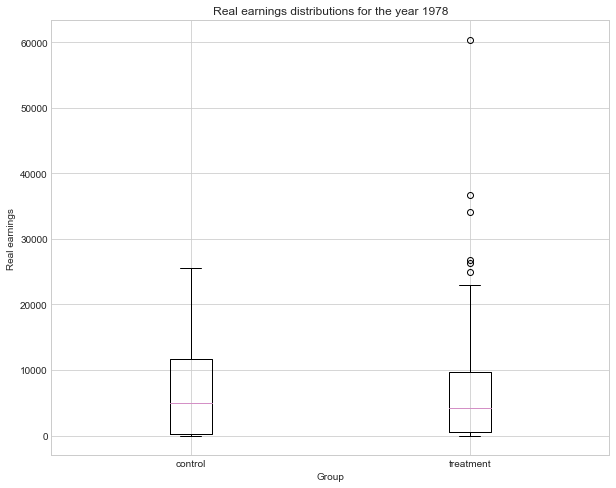

In [13]:
#create a figure

#Style
sns.set_style('whitegrid')
sns.set_palette('cubehelix',2)

#Figure
plt.figure(figsize=(10,8))
plt.boxplot([data_control.re78,data_treat.re78],0)

#Labels
plt.ylabel('Real earnings')
plt.xlabel('Group')    
plt.title('Real earnings distributions for the year 1978')
plt.xticks([1,2],['control','treatment'])

The difference between the distributions of the 2 groups is not as striking that one would expect. We observe that the medians are quite similar and both distrubutions have a longer tail towards the higher earnings. This is most likely due to the fact that some people have real earnings equal to zero. Wealso observe that the treatment group have a few more outiers than the control group.

To confirm the results of this graph, we create a table containing the numerical values of these statistics.

In [32]:
#Descriptive statistics 
descrip = pd.DataFrame()
descrip['control'] = data_control['re78'].describe()
descrip['treatment'] = data_treat['re78'].describe()
descrip

,control,treatment
count,429.000000,185.000000
mean,6984.169742,6349.143530
std,7294.161791,7867.402218
min,0.000000,0.000000
25%,220.181300,485.229800
50%,4975.505000,4232.309000
75%,11688.820000,9642.999000
max,25564.670000,60307.930000


In the table above, we see that both the median and the mean are actually higher in the control group. Although the treatment group has some big outliers (as observed on the boxplot) the control group has a larger 75% quantile which means it has more people in this group having larger salaries.
We also notice that the treatment group has zero real earnings, which means that some of the trained people ended up unemployed anyway.
In the light of this superficial analysis, one might conclude that the training didn't work, or even decreased people's chances at a better salary.

In [33]:
#plt.figure(figsize=(16, 16))
#Bins = 20#%linspace(0,10000,2000)
#plt.title('histogram of the salaries through the years')
#plt.subplot(321)
data_control.re74.hist(bins=Bins,color='blue')
plt.title('count for year 1974- control group')
plt.xlabel('salary')
plt.subplot(322)
data_treat.re74.hist(bins=Bins,color='red')
plt.title('count for year 1974 - treatment group')
plt.xlabel('salary')

plt.subplot(323)
data_control.re75.hist(bins=Bins,color='blue')
plt.title('count for year 1975- control group')
plt.xlabel('salary')
plt.subplot(324)
data_treat.re75.hist(bins=Bins,color='red')
plt.title('count for year 1975 - treatment group')
plt.xlabel('salary')

plt.subplot(325)
data_control.re78.hist(bins=Bins,color='blue')
plt.title('count for year 1978- control group')
plt.xlabel('salary')
plt.subplot(326)
data_treat.re78.hist(bins=Bins,color='red')
plt.title('count for year 1978 - treatment group')
plt.xlabel('salary')

NameError: name 'Bins' is not defined

In [ ]:
Means = pd.DataFrame([data_treat['re74'].mean(),data_treat['re75'].mean(),data_treat['re78'].mean()])
Means.index=['1974','1975','1978']
Means.columns=['mean_treatment']
Means['mean_control']=[data_control['re74'].mean(),data_control['re75'].mean(),data_control['re78'].mean()]

Means['non-zero salaries_treatment']=[len(data_treat.re74[data_treat.re74!=0]),len(data_treat.re75[data_treat.re75!=0]),len(data_treat.re78[data_treat.re78!=0])]
Means['non-zero salaries_treatment']=100*Means['non-zero salaries_treatment']/len(data_treat)

Means['non-zero salaries_control']=[len(data_control.re74[data_control.re74!=0]),len(data_control.re75[data_control.re75!=0]),len(data_control.re78[data_control.re78!=0])]
Means['non-zero salaries_control']=100*Means['non-zero salaries_control']/len(data_control)

Means['non-zero mean_treatment']=[data_treat.re74[data_treat.re74!=0].mean(),data_treat.re75[data_treat.re75!=0].mean(),data_treat.re78[data_treat.re78!=0].mean()]
Means['non-zero mean_control']=[data_control.re74[data_control.re74!=0].mean(),data_control.re75[data_control.re75!=0].mean(),data_control.re78[data_control.re78!=0].mean()]

Means

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Answer :

We will now perform a deeper analysis of the problem. Indeed, since this data is collected from an observational study, the assignment process into treatment or control groups might not have been completely random. In order to check this, we will study the distributions of the rest of the variables and try to detect any differences between the two groups.

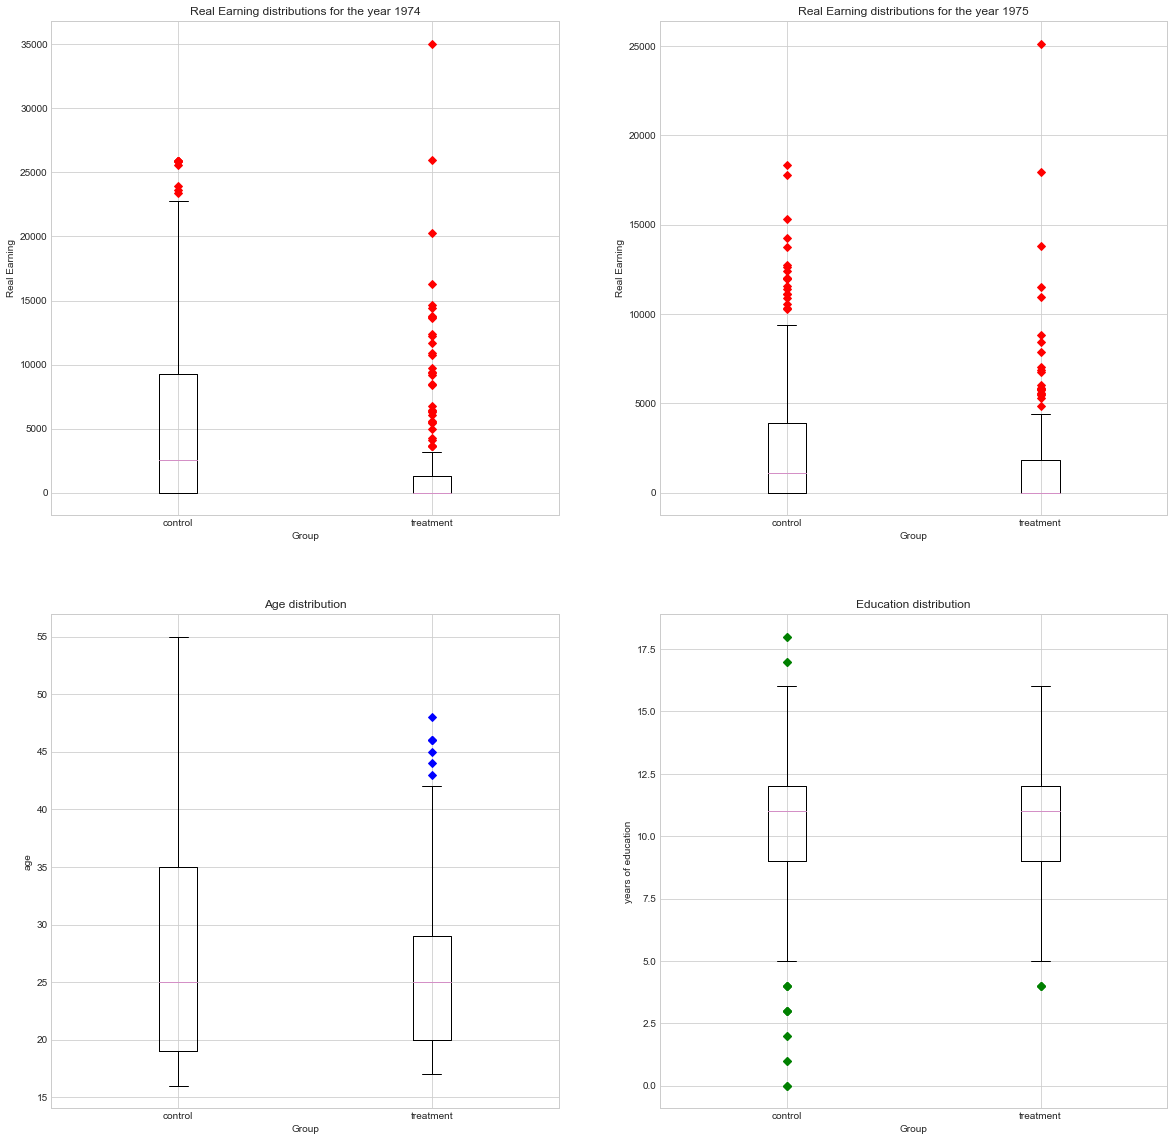

In [34]:
#figure
plt.figure(figsize=(20,20))

#boxplot for real ernings 1974
plt.subplot(221)
plt.boxplot([data_control.re74,data_treat.re74],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1974')
plt.xticks([1,2],['control','treatment'])

#boxplot for real earnings 1975
plt.subplot(222)
plt.boxplot([data_control.re75,data_treat.re75],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1975')
plt.xticks([1,2],['control','treatment'])

#boxplot for age
plt.subplot(223)
plt.boxplot([data_control.age,data_treat.age], 0, 'bD')    
plt.title('Age distribution')
plt.ylabel('age')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])

#boxplot for education
plt.subplot(224)
plt.boxplot([data_control.educ,data_treat.educ], 0, 'gD')    
plt.title('Education distribution')
plt.ylabel('years of education')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])
plt.show()

We start with boxplots of the real earnings for the years preceeding the treatment.
From the boxplots above, we can clearly see that the medians in the treatment groups are equal to zero, which means that at least half of the group was unemployed before the treatment. The control group however shows a positive median, as well as  larger 75% quantiles. Although the treatment group shows some extreme outliers, it seems that overall, the people who are involved tend to have lower initial salaries.
This might be interpreted as a discriminating factor between the groups: since they didn't start at the same level of income, they cannot be fairly compared after the treatment. Thus we conclude that the naive analysis we did in the previous question is in fact invalid.

The boxplots of age and education confirm that the groups are not balanced. Although the distributions are not too different (i.e we cannot say that one group is younger than the other or more educated), the fact that the control group is larger (429), makes it cover a broader range of age and education values. 

Finally, we compute the proportion of each categorical variable in the groups.

In [38]:
#ratios 
#compute the number of black/hispanic/married/nodegree person in each group
control_ratio = data_control.iloc[:,4:8].sum()
treat_ratio = data_treat.iloc[:,4:8].sum()

#divide it by the total size of the group 
ratio = pd.DataFrame([100*control_ratio/len(data_control),100*treat_ratio/len(data_treat)])
ratio.index = ['control','treatment']
np.round(ratio,decimals=1)

,black,hispan,married,nodegree
control,20.3,14.2,51.3,59.7
treatment,84.3,5.9,18.9,70.8


The ratios are not the equal for both groups, the most striking difference can be seen in the proportion of black people (20% of the control group and more than 80% of the treatment group ).
This confirms that the control and treatment groups do not represent the same population and thus the effect of the treatment cannot be judged accurately when compared to this control group.

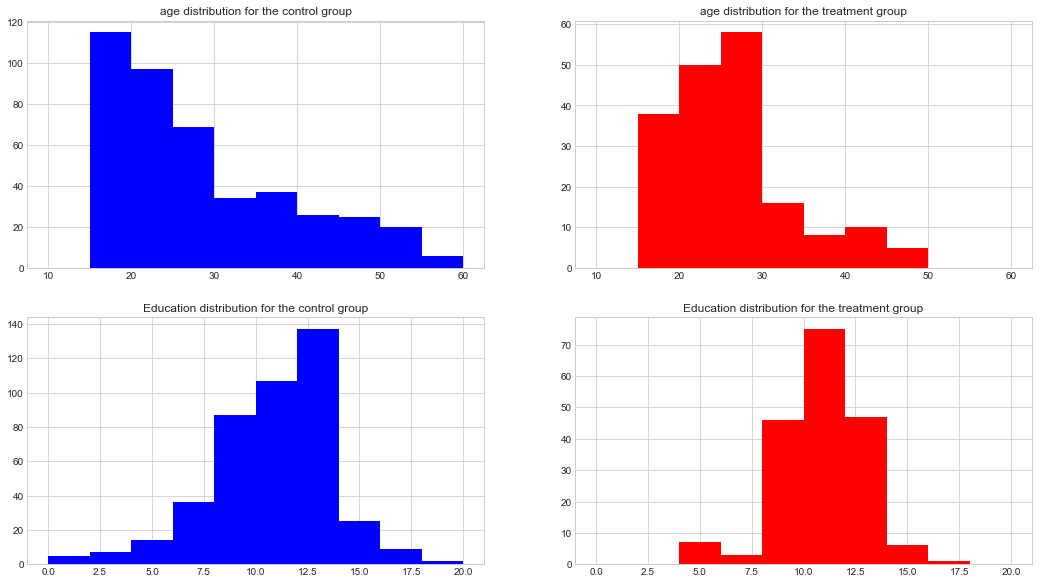

In [39]:
#histogram for age and education
plt.figure(figsize=(18, 10))
plt.subplot(221)
data_control.age.hist(bins=[10,15,20,25,30,35,40,45,50,55,60], color='blue')    
plt.title('age distribution for the control group')
plt.subplot(223)
data_control.educ.hist(bins=[0,2,4,6,8,10,12,14,16,18,20], color='blue')    
plt.title('Education distribution for the control group')
plt.subplot(222)
data_treat.age.hist(bins=[10,15,20,25,30,35,40,45,50,55,60], color='red')      
plt.title('age distribution for the treatment group')
plt.subplot(224)
data_treat.educ.hist(bins=[0,2,4,6,8,10,12,14,16,18,20], color='red')    
plt.title('Education distribution for the treatment group')

plt.show()

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Answer : 
In this section, we will compute the propensity scores via logistic regression in order to estimate the probability for each person of receiving the treatment given their known characteristics.

In [40]:
from sklearn import linear_model
logistic = linear_model.LogisticRegression()

In [41]:
#F´fitting logistic model to relevant parameters
covariates =data[['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74','re75']]
X = covariates
Z = data.treat
logistic.fit(X,Z)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
#logistic.coef_

In [42]:
propensity = logistic.predict_proba(X)

array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       ..., 
       [ 0.87687096,  0.12312904],
       [ 0.44954003,  0.55045997],
       [ 0.84497047,  0.15502953]])

In [31]:
#precision = cross_val_score(logistic, X, Z, cv=10, scoring="precision")
#recall = cross_val_score(logistic, X, Z, cv=10, scoring="recall")

#print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
#print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

In [46]:
#adding the probabilities for each individual to the dataframe
prop = pd.DataFrame(propensity)
prop.columns = ['prob_control' ,'prob_treat']
data = pd.concat([data,prop],axis=1)

data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_control,prob_treat
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.556650,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.855340,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.277645,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.335849,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.301714,0.698286


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?
#### Answer:



In order to perfom the matching, we must first translate our data into a bipartite graph C $\cup$ T, where each node is an observation from the data and C is the subset of control observations and T is the subset of treatment observations.
We assign to each node a list of attributes that will help construct the edges. For now these attributes consists of the propensity score and an indicator of wether the person was treated or not.

Our matching aims at linking together pairs of control and treatment observations which have close propensity scores.

For this purpose, we assign to each edge a weight defined as the absolute difference between the propensities of its nodes.
We then apply a maximum weighted matching to our graph 

Since the graph is bipartite the edges only exist between nodes of different subsets.

In [35]:
#create  a bipartite graph from the data 
#for each node we add attributes about its propensity, and wether it is in the treatment group or not 
import networkx as nx
G = nx.Graph()
for k in range(len(data)):
        G.add_node(k, idf=data.id[k],prop= data.prob_treat[k],treat=data.treat[k])
# view an example         
G.nodes(1)[0]

(0, {'idf': 'NSW1', 'prop': 0.44335042297442523, 'treat': 1})

In [55]:
#adding the edges 
for i in G.nodes():
    for j in G.nodes():
        #the edges  go from all treatment nodes to all control nodes 
        if ((G.nodes(1)[i][1]['treat']==1) & (G.nodes(1)[j][1]['treat']==0)):
            # we assign -the absolute value of the propensity difference in order to apply 
            #max. weight matching later
            W=-abs(G.nodes(1)[i][1]['prop']-G.nodes(1)[j][1]['prop'])
            G.add_edge(i, j, weight=W )

In [56]:
# We could draw the graph but the outcome is not readable
#nx.draw(G, with_labels=True, font_weight='bold')
print ('number of nodes in the graph: '+str(G.number_of_nodes()))
print('number of edges in the graph: '+str(G.number_of_edges()))
#We check if the graph is bipartite: 
if (nx.is_bipartite(G)):
    print( 'the graph is bipartite')

number of nodes in the graph: 614
number of edges in the graph: 79365
the graph is bipartite


In [57]:
#We do the matching using the maximum weight matching
matching=nx.max_weight_matching(G,True)

In [58]:
#the subsets created by the matching
T=data[data.treat==1]
C=pd.DataFrame([])
for k in range(0,185):
    C=pd.concat([C,data[data.index==matching[k]]])


In [59]:
T.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_control,prob_treat
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.438131,0.561869
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.211763,0.211763
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244085,0.040171
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.293196,0.475299
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,0.330664,0.669336
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,0.524701,0.706804
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,0.959829,0.755915


In [60]:
C.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_control,prob_treat
count,185.0,185.000000,185.000000,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.0,23.713514,10.162162,0.47027,0.118919,0.167568,0.627027,2095.885961,1615.306428,5312.474907,0.628934,0.371066
std,0.0,9.644726,2.861984,0.50047,0.324571,0.374495,0.484907,4029.201886,2674.747685,5842.884861,0.252452,0.252452
min,0.0,16.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221902,0.040057
25%,0.0,17.000000,9.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.321448,0.155030
50%,0.0,19.000000,10.000000,0.00000,0.000000,0.000000,1.000000,289.971500,451.161300,3392.860000,0.816256,0.183744
75%,0.0,26.000000,12.000000,1.00000,0.000000,0.000000,1.000000,2068.986000,1890.581000,7933.914000,0.844970,0.678552
max,0.0,55.000000,18.000000,1.00000,1.000000,1.000000,1.000000,21918.320000,13776.530000,20243.380000,0.959943,0.778098


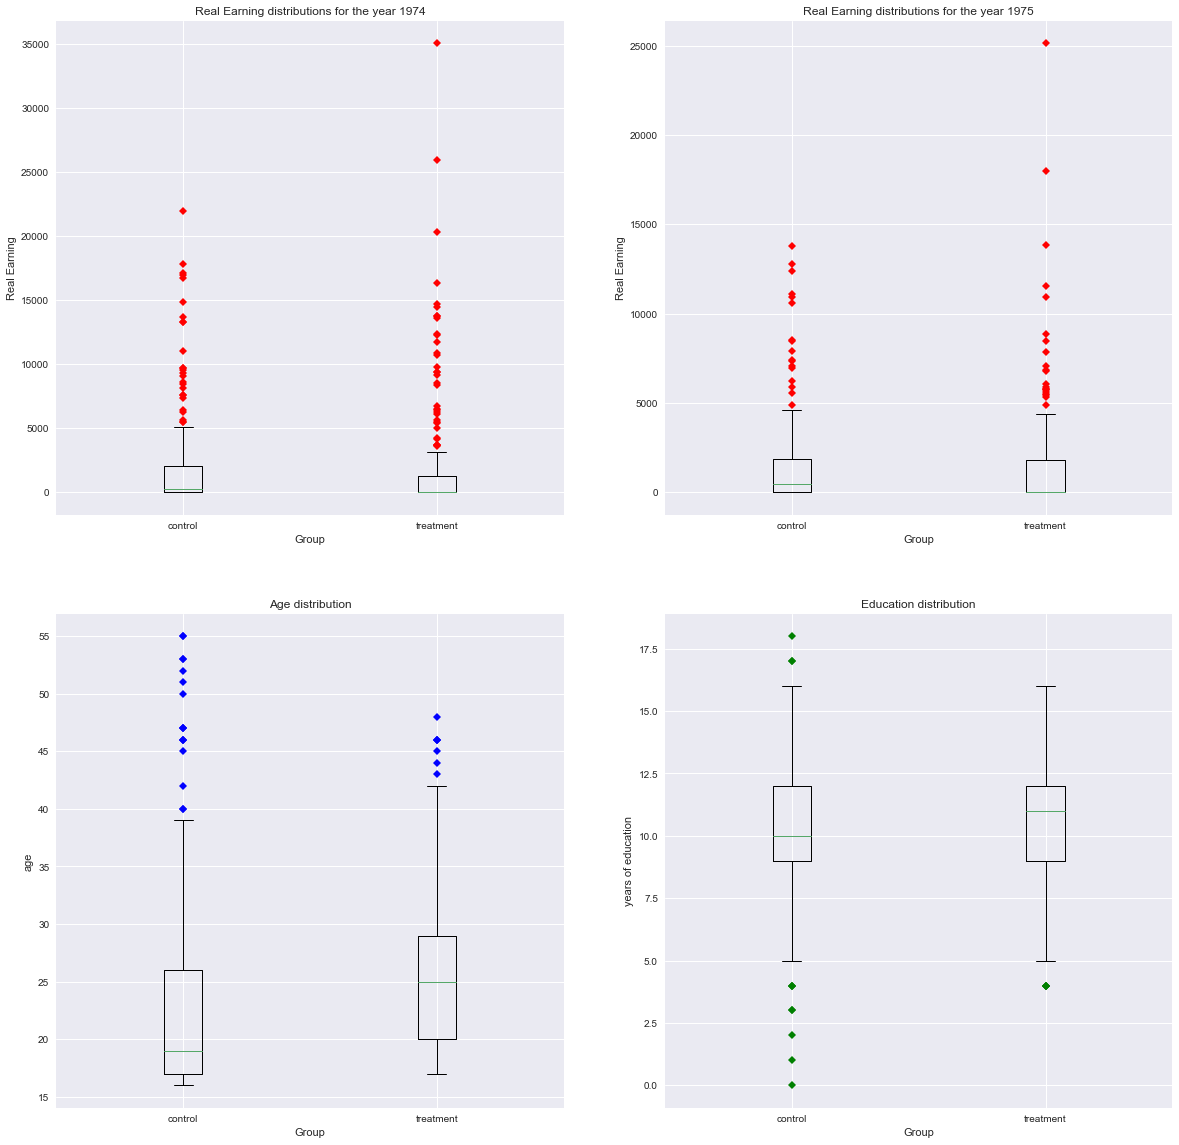

In [61]:
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.boxplot([C.re74,T.re74],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1974')
plt.xticks([1,2],['control','treatment'])

plt.subplot(222)
plt.boxplot([C.re75,T.re75],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1975')
plt.xticks([1,2],['control','treatment'])

#boxplot for age and education
plt.subplot(223)
plt.boxplot([C.age,T.age], 0, 'bD')    
plt.title('Age distribution')
plt.ylabel('age')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])

plt.subplot(224)
plt.boxplot([C.educ,T.educ], 0, 'gD')    
plt.title('Education distribution')
plt.ylabel('years of education')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])
plt.show()

In [62]:


#ratios 
#compute the number of black /hispanic/married/nodegree person in each group
C_ratio=C.iloc[:,4:8].sum()
T_ratio=T.iloc[:,4:8].sum()

# divide it by the total size of the group 
ratio=pd.DataFrame([100*C_ratio/len(C),100*T_ratio/len(T)])
ratio.index=['control','treatment']
ratio

,black,hispan,married,nodegree
control,47.027027,11.891892,16.756757,62.702703
treatment,84.324324,5.945946,18.918919,70.810811


([<matplotlib.axis.XTick at 0x11a123dd8>,
 <a list of 2 Text xticklabel objects>)

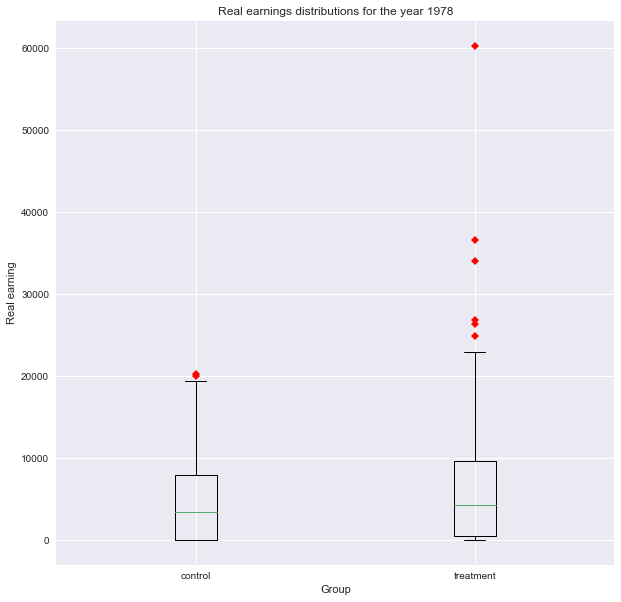

In [63]:
#create a figure and 1x3 subplots 
plt.figure(figsize=(10,10))
plt.boxplot([C.re78,T.re78],0, 'rD')
plt.ylabel('Real earning')
plt.xlabel('Group')    
plt.title('Real earnings distributions for the year 1978')
plt.xticks([1,2],['control','treatment'])

In [78]:
#T_bal= T
#C_bal=C
#C_bal.index=range(0,185)
#difference = C_bal.black - T_bal.black
#C_bal=C_bal[difference==0]
#T_bal=T_bal[difference==0]


In [87]:
#C_bal.describe()

In [88]:
#T_bal.describe()

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

In [71]:
import networkx as nx
#we create a new graph , this time adding black as an attribute to the nodes
G2 = nx.Graph()
for k in range(len(data)):
        G2.add_node(k, idf=data.id[k],prop= data.prob_treat[k],treat=data.treat[k],black=data.black[k],age=data.age[k])
G2.nodes(1)[0]       

(0,
 {'age': 37,
  'black': 1,
  'idf': 'NSW1',
  'prop': 0.44335042297442523,
  'treat': 1})

In [72]:
#we add edges between the nodes,
#this time we make sure that 
for i in G2.nodes():
    for j in G2.nodes():
        if ((G2.nodes(1)[i][1]['treat']==1) & (G2.nodes(1)[j][1]['treat']==0)&(G2.nodes(1)[j][1]['black']==G2.nodes(1)[i][1]['black'])&(abs(G2.nodes(1)[j][1]['age']-G2.nodes(1)[i][1]['age']))<2):
            W=-abs(G2.nodes(1)[i][1]['prop']-G2.nodes(1)[j][1]['prop'])
            G2.add_edge(i, j, weight=W )

In [73]:
print ('number of nodes in the graph: '+str(G2.number_of_nodes()))
print('number of edges in the graph: '+str(G2.number_of_edges()))
#We check if the graph is bipartite: 
if (nx.is_bipartite(G2)):
    print( 'the graph is bipartite')

number of nodes in the graph: 614
number of edges in the graph: 188805


In [74]:
# we do the max. weight matching 
matching=nx.max_weight_matching(G2,True)

In [75]:
#We create the resulting subsets
T2=pd.DataFrame([])
C2=pd.DataFrame([])
for k in range(0,185):
    if k in matching:
        T2=pd.concat([T2,data[data.index==k]])
        C2=pd.concat([C2,data[data.index==matching[k]]])


In [76]:
T2.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_control,prob_treat
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530,0.438131,0.561869
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218,0.211763,0.211763
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244085,0.040171
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800,0.293196,0.475299
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000,0.330664,0.669336
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000,0.524701,0.706804
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000,0.959829,0.755915


In [77]:
C2.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_control,prob_treat
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,0.562162,25.216216,10.297297,0.837838,0.032432,0.189189,0.697297,1969.406295,1407.572085,5688.019013,0.438025,0.561975
std,0.497467,8.555875,2.142541,0.369600,0.177626,0.392722,0.460674,3875.322475,2865.524276,7422.129584,0.211604,0.211604
min,0.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.234957,0.040291
25%,0.000000,19.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.293000,0.475299
50%,1.000000,23.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3406.160000,0.330664,0.669336
75%,1.000000,28.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1714.358000,1890.581000,8546.715000,0.524701,0.707000
max,1.000000,53.000000,16.000000,1.000000,1.000000,1.000000,1.000000,21918.320000,25142.240000,60307.930000,0.959709,0.765043


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

#### Answer : 

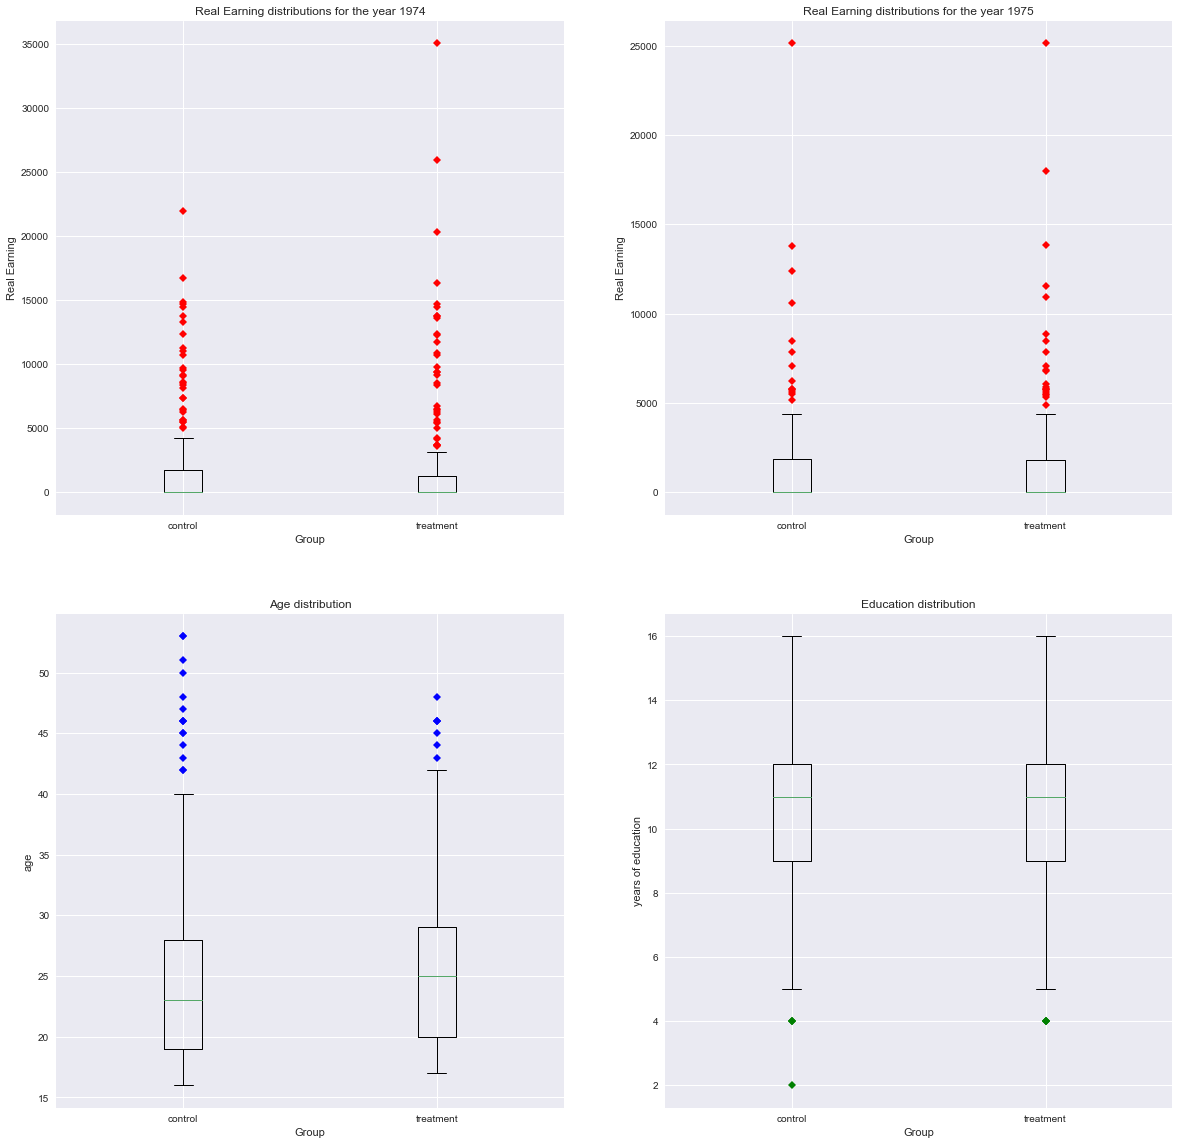

In [78]:
plt.figure(figsize=(20,20))

plt.subplot(221)
plt.boxplot([C2.re74,T2.re74],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1974')
plt.xticks([1,2],['control','treatment'])

plt.subplot(222)
plt.boxplot([C2.re75,T2.re75],0, 'rD')
plt.ylabel('Real Earning')
plt.xlabel('Group')    
plt.title('Real Earning distributions for the year 1975')
plt.xticks([1,2],['control','treatment'])

#boxplot for age and education
plt.subplot(223)
plt.boxplot([C2.age,T2.age], 0, 'bD')    
plt.title('Age distribution')
plt.ylabel('age')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])

plt.subplot(224)
plt.boxplot([C2.educ,T2.educ], 0, 'gD')    
plt.title('Education distribution')
plt.ylabel('years of education')
plt.xlabel('Group')    
plt.xticks([1,2],['control','treatment'])
plt.show()

In [79]:
#ratios 
#compute the number of black /hispanic/married/nodegree person in each group
C2_ratio=C2.iloc[:,4:8].sum()
T2_ratio=T2.iloc[:,4:8].sum()

# divide it by the total size of the group 
ratio=pd.DataFrame([100*C2_ratio/len(C2),100*T2_ratio/len(T2)])
ratio.index=['control','treatment']
ratio

,black,hispan,married,nodegree
control,83.783784,3.243243,18.918919,69.729730
treatment,84.324324,5.945946,18.918919,70.810811


([<matplotlib.axis.XTick at 0x116af4438>,
 <a list of 2 Text xticklabel objects>)

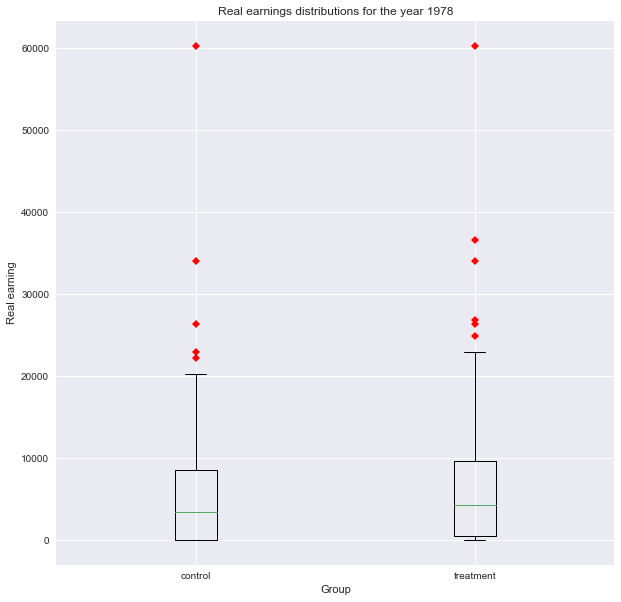

In [80]:
#create a figure and 1x3 subplots 
plt.figure(figsize=(10,10))
plt.boxplot([C2.re78,T2.re78],0, 'rD')
plt.ylabel('Real earning')
plt.xlabel('Group')    
plt.title('Real earnings distributions for the year 1978')
plt.xticks([1,2],['control','treatment'])

# Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

## Part 1

- Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

### Solution

Import libraries:

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

We retrieve the articles from the sklearn dataset. We can see the 20 categories that we are going to cluster the articles into. We decided to get the data in a random order so that we do not have to randomize the order later when splitting the data into training, testing and validation datasets.

In [3]:
#Fetch data. We download the data if it is not saved already.
newsgroups20 = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, download_if_missing=True)

#20 news categories
categories = newsgroups20.target_names

#printing it!
print ("The 20 categories are:")
pprint(list(newsgroups20.target_names))


The 20 categories are:
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [5]:
#Function to separate the documents into tokens by splitting on spaces and changing all characters to lowercase.
tokenize = lambda doc: doc.lower().split(" ")

# We create the sklearn TFIDF vectorizer, and compute the tfidf features of the data.
tfidf = TfidfVectorizer(tokenizer=tokenize)
tfidf_results = tfidf.fit_transform(newsgroups20.data)

print(tfidf_results)

  (0, 282387)	0.0140258057605
  (0, 365517)	0.113522139385
  (0, 237867)	0.11127683307
  (0, 450247)	0.110280777821
  (0, 123734)	0.117802347049
  (0, 423435)	0.430992321225
  (0, 268816)	0.147765943013
  (0, 451143)	0.121668965308
  (0, 434140)	0.0520731444266
  (0, 405733)	0.0896450297201
  (0, 197952)	0.0714324612804
  (0, 373078)	0.0757326847264
  (0, 428627)	0.0729556662549
  (0, 417615)	0.0744050019808
  (0, 77954)	0.083588891865
  (0, 431478)	0.136434968273
  (0, 150033)	0.108705621629
  (0, 506414)	0.0461762191086
  (0, 490927)	0.0306860931226
  (0, 173795)	0.13098527592
  (0, 402464)	0.0926395655756
  (0, 160883)	0.0460336953254
  (0, 437567)	0.0542189115102
  (0, 216675)	0.0854213348028
  (0, 137875)	0.0557677685832
  :	:
  (18845, 273981)	0.102179157679
  (18845, 104201)	0.102179157679
  (18845, 94404)	0.102179157679
  (18845, 225732)	0.102179157679
  (18845, 48685)	0.102179157679
  (18845, 31750)	0.102179157679
  (18845, 31749)	0.102179157679
  (18845, 153856)	0.10217915767

Next we separate the data into training, testing and validation data sets. We don't randomize it since we loaded the data in random order earlier.

In [28]:
data_len = len(newsgroups20.data)

data_80 = 8 * int(data_len / 10)
data_90 = 9 * int(data_len / 10)

#80% training data
train_tfidf = tfidf_results[:data_80]
train_data = newsgroups20['target'][:data_80]

#10% testing data
test_tfidf = tfidf_results[data_80:data_90]
test_data = newsgroups20['target'][data_80:data_90]

#10% validation data
val_tfidf = tfidf_results[data_90:]
val_data = newsgroups20['target'][data_90:]

## Part 2

- Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

Import libraries:

In [2]:
from sklearn.ensemble import RandomForestClassifier